# Resultados de sociograma

In [2]:
import numpy as np
import math   
import matplotlib.pyplot as plt

## Mejoras a realizar

- Diferenciar la primera elección de la segunda.
- Colorear de diferentes colores la primera opción de la segunda
(idealmente poner una flag en caso que se quiera pintar todo de negro)
- Contar cantidad de votos y ordenar el arreglo en orden descendente según la cantidad de votos.
- Investigar que otras preguntas se pueden hacer u otras formas de mostrar/graficar los resultados.

## Preguntas del Sociograma

### I) ¿Con qué dos personas le gustaría trabajar en grupo?

Como resultado obtenemos los referentes del grupo. Los que se relacionan con todos, los más escuchados y los que marcan cierto liderazgo y/o son el apoyo emocional del grupo.

### II) ¿Cuáles son las personas que me gustaría conocer mejor?

Los no votados, o son íntimos de todos, o no son aceptados.
En este caso hay que estudiar el por qué, y también de hacer algo para mejorar la situación.

Presentar el afiche con el gráfico y la sociomatriz y se hace notar quiénes son los más votados y los menos votados.
No se hace ningún comentario sobre estos últimos.
Se explican las coherencias del dibujo, o sea las preferencias o rechazos.

### III) ¿Quiénes podrían darse a conocer más pero no se animan?

El objetivo es impulsar, dejar la invitación a que a partir de ahora cada uno asuma como protagonista la vida de la comunidad, ya no podemos esperar que nos llegue todo hecho, ahora es cada uno quién debe hacer su parte.
Asumir que otros me digan que puedo dar más y que tengo talentos me debe impulsar a dar todo de mi para ofrecerlo a la comunidad.

## Lista de integrantes

In [3]:
equipo = np.array(["Fede",  #0
                   "Nachi", #1
                   "Clari", #2
                   "Geni",  #3
                   "Ivan",  #4
                   "Juli",  #5
                   "Lupa",  #6
                   "May",   #7
                   "Nico",  #8
                   "Octi",  #9
                   "Zeta",  #10
                   "Toti",  #11
                   "Trini"  #12
                   ])

usuarios = np.array(["Tomás\nSantillán",     #0
                     "Sofía\nMarshall",      #1
                     "Consuelo\nQuevedo",    #2
                     "Giuliana\nDe Luca",    #3
                     "Lucía\nQuiroga",       #4
                     "Emilia\nHerrera",      #5
                     "Valentina\nLobo",      #6
                     "Luciano\nCortesini",   #7
                     "Lucía\nAbiega",        #8
                     "Rebecca\nMartinez",    #9
                     "Virginia\nBonsignori", #10
                     "Micaela\nCapdevila",   #11
                     "Azul\nVittar",         #12
                     "Tomás\nDíaz",          #13
                     "Rocío\nChiggio",       #14
                     "Nicolás\nWilkys",      #15
                     "Ezequiel\nReyes"       #16
                     ])

## Lista de aristas entre integrantes

In [12]:
# Sociograma I

aristas_usuarios_I = np.array([(0, 5), (0, 8), (12, 7), (12, 5), (14, 9), (14, 4), (8, 5), (8, 9),
                               (16, 6), (16, 0), (1, 12), (1, 8), (4, 1), (4, 10), (2, 1), (2, 5),
                               (5, 0), (5, 4), (13, 0), (13, 8), (10, 7), (10, 14), (11, 7), (11, 0),
                               (6, 7), (6, 12), (9, 5), (9, 8), (15, 14), (15, 12), (7, 0), (7, 4), (3, 5), (3, 12)])

aristas_equipo_I = np.array([(7, 12), (7, 1), (11, 0), (11, 1), (12, 7), (12, 8), (4, 8), (4, 6), (2, 12),
                             (2, 10), (3, 10), (3, 6), (1, 4), (1, 12), (8, 12), (8, 9), (9, 2), (9, 8),
                             (0, 1), (0, 8), (10, 4), (10, 11), (5, 1), (5, 12), (6, 10), (6, 7)])

# Sociograma II

aristas_usuarios_II = np.array([(2, 3), (2, 7), (11, 9), (11, 14), (14, 8), (14, 9), (12, 7), (12, 0), 
                                (4, 7), (4, 3), (10, 3), (10, 15), (5, 16), (5, 12), (13, 4), (13, 1), 
                                (7, 5), (7, 12), (16, 3), (16, 1), (6, 1), (6, 4), (3, 0), (3, 2), 
                                (15, 1), (15, 10), (1, 4), (1, 11), (0, 12), (0, 7), (8, 9), (8, 3)])

aristas_equipo_II = np.array([(3, 5), (3, 12), (7, 8), (7, 10), (1, 10), (1, 12), (9, 10), (9, 7), (2, 5), (2, 4),
                              (8, 7), (8, 4), (5, 3), (5, 2), (0, 10), (0, 11), (4, 7), (4, 10), (12, 1),
                              (12, 11), (11, 10), (11, 5), (10, 8), (10, 2), (6, 0), (6, 2)])

# Sociograma III

aristas_usuarios_III = np.array([(5, 16), (5, 3), (6, 16), (6, 3), (7, 16), (7, 3), (16, 15), (16, 2),
                                 (2, 11), (2, 3), (15, 2), (15, 12), (12, 7), (12, 13), (13, 7), (13, 5),
                                 (3, 13), (3, 2), (0, 3), (0, 13), (8, 3), (8, 14), (1, 2), (1, 13), (10, 14),
                                 (10, 13), (14, 3), (14, 13), (4, 14), (4, 16), (11, 3), (11, 13), (9, 2), (9, 13)])

aristas_equipo_III = np.array([(6, 3), (6, 11), (11, 4), (11, 7), (7, 1), (7, 2), (8, 4), (8, 11), (3, 7), (3, 12), 
                               (10, 7), (10, 8), (9, 3), (9, 6), (1, 6), (1, 11), (0, 4), (0, 2), (12, 3), (12, 4),
                               (5, 0), (5, 11), (4, 0), (4, 3), (2, 0), (2, 11)])

## Cálculo de pocisiones para circuscribir integrantes en circunferencia

In [5]:
def membersCoordinates(array):
  deltaPi = (2 * math.pi) / len(array)
  x = []
  y = []
  for i in range(len(array)):
    x.append(math.cos(i * deltaPi))
    y.append(math.sin(i * deltaPi))
  x = np.array(x)
  y = np.array(y)
  return x, y

## Cálculo de pocisiones de aristas

In [6]:
def edgesCoordinates(x, y, pairs):
  edgesx = []
  edgesy = []
  for pair in pairs:
    edgesx.append([x[pair[0]], x[pair[1]]])
    edgesy.append([y[pair[0]], y[pair[1]]])
  edgesx = np.array(edgesx)
  edgesy = np.array(edgesy)
  return edgesx, edgesy

## Mostrar gráfico de integrantes en circunferencia

In [7]:
def drawGraph(array, edges):
  x, y = membersCoordinates(array)
  edgesx, edgesy = edgesCoordinates(x, y, edges)
  
  # Configuración de la figura
  plt.figure(figsize=(len(array)/2, len(array)/2))
  plt.xlim(-1.1, 1.1)
  plt.ylim(-1.1, 1.1)
  plt.axis('off')
  plt.axis('square')

  # Ploteamos los integrantes
  for i, txt in enumerate(array):
    plt.text(x[i], y[i], txt,
             bbox = {'facecolor': 'white', 'alpha': 0.9, 'boxstyle': "circle"},
             verticalalignment='center', horizontalalignment='center')

  # Ploteamos las aristas
  for i in range(len(edgesx)):
    plt.plot(edgesx[i], edgesy[i], color="black", linewidth=1)

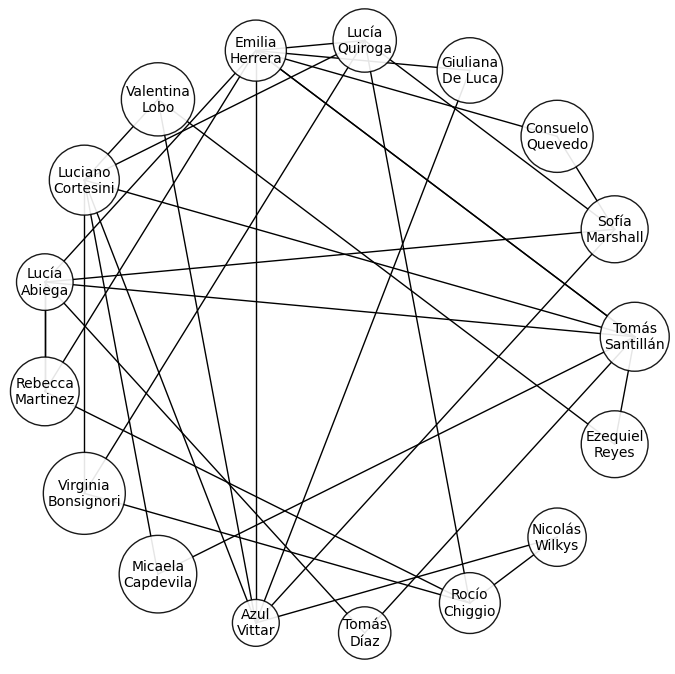

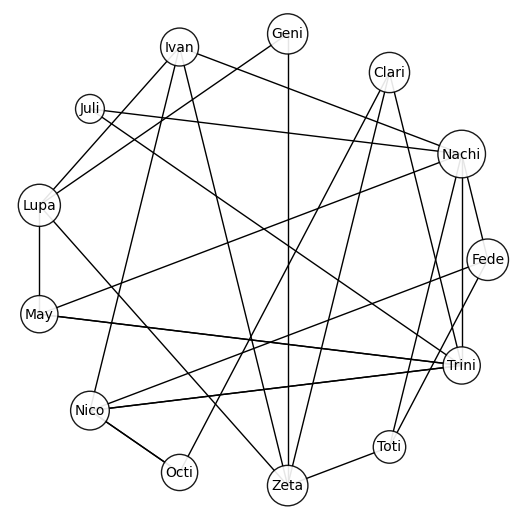

In [8]:
# Sociograma I
drawGraph(usuarios, aristas_usuarios_I)
drawGraph(equipo, aristas_equipo_I)

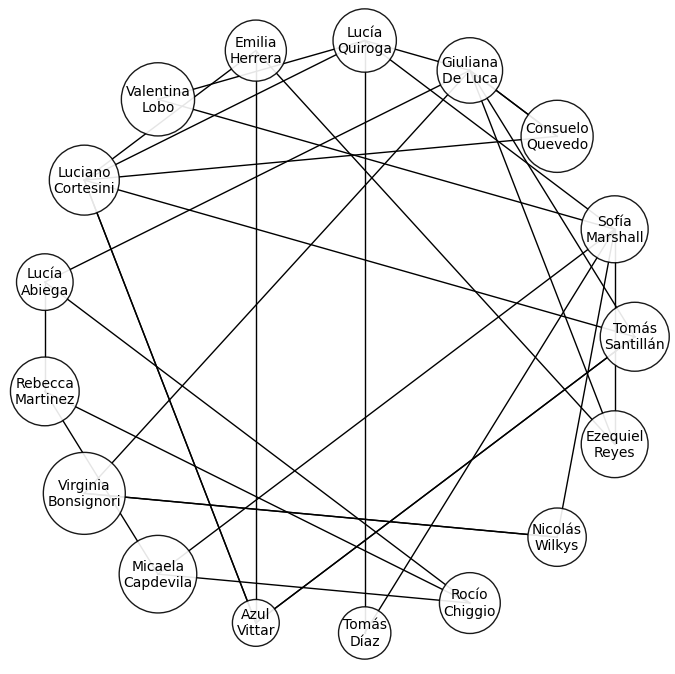

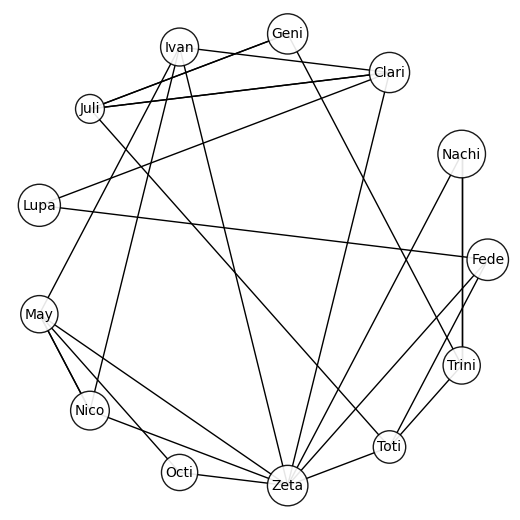

In [9]:
# Sociograma II
drawGraph(usuarios, aristas_usuarios_II)
drawGraph(equipo, aristas_equipo_II)

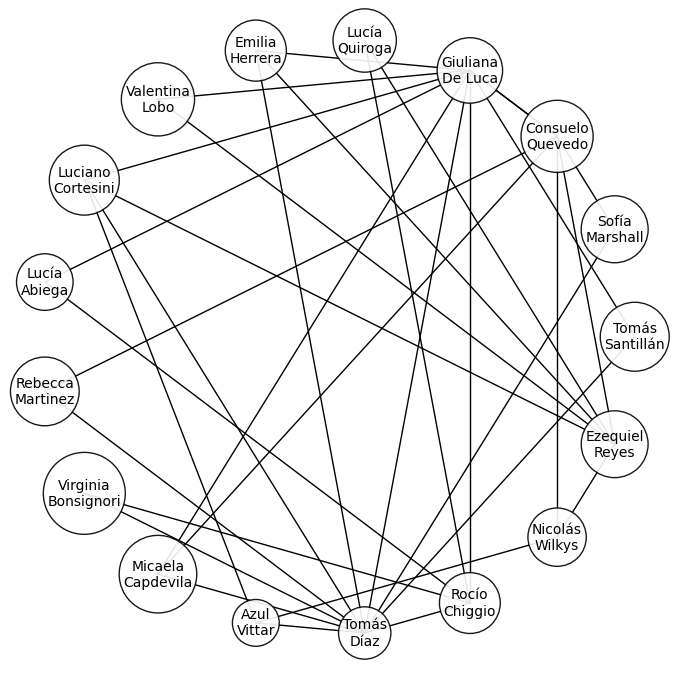

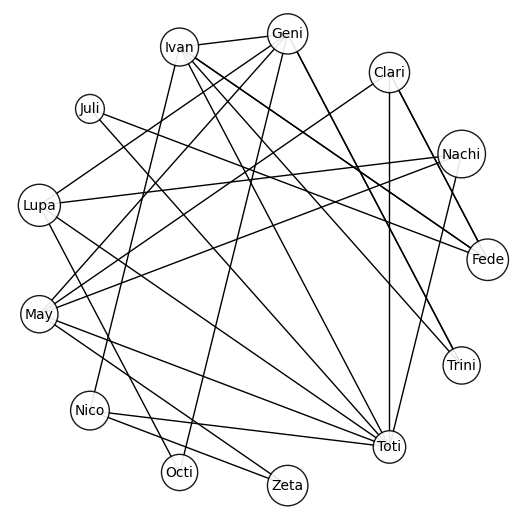

In [13]:
# Sociograma III
drawGraph(usuarios, aristas_usuarios_III)
drawGraph(equipo, aristas_equipo_III)